# Actor-Critic Methods

In _value-based_ methods, we use a value function to determine the optimal policy. The exploration
and exploitation tradeoff is left to manual tuning. In _policy-based_ methods, we learn the policy
directly, but the Monte Carlo methods have high-variance and tend to be slower (mitigating that by
collecting more samples causes the algorithm to be less sample-efficient).

Actor-critic methods combine the two approaches:

- We learn the _actor_ policy, to control how the agent behave.
- We measure how good the chosen actions are via a _critic_, which learns the value function.

Remember the _baseline_ in policy gradient? The _critic_ helps computing it!


In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import gymnasium as gym

from util.gymnastics import DEVICE, gym_simulation
from util.gymnastics import init_random, plot_scores
from util.rl_algos import ReplayBuffer, Experience, soft_update_model_params

## Training Loop

For simplicity, use a simple training loop with a single environment collecting and learning single
trajectories. All the algorithms in this notebook would benefit greatly from multiple trajectories
and vectorized environments, and most standard implementations do so.

NOTE: certain actor-critic algorithms benefit from adding noise during training. Hence, we include
that flag in the `act` call for simplicity in this notebook.


In [ ]:
def train_actor_critic(
    env: gym.Env, agent, n_episodes=10_000, max_t=300, solved_score=-370, log_every=50
):
    scores = []
    for i_episode in range(1, n_episodes + 1):
        state, _ = env.reset()
        score = 0
        for _ in range(max_t):
            action = agent.act(state, add_noise=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores.append(score)
        avg_score = np.mean(scores[-100:])
        print(
            f"\rEpisode {i_episode}\tAverage Score: {avg_score:.2f}",
            end="\n" if i_episode % log_every == 0 else "",
        )
        if avg_score >= solved_score:
            print(f"\rEpisode {i_episode} solved environment!\tAverage Score: {avg_score:.2f}")
            break

    return scores

## Advantage Actor Critic (A2C)

The simplified version of a general 1-step [actor-critic](https://arxiv.org/abs/1602.01783)
algorithm goes as follows:

1.  In state $S_t$, the _actor_ outputs the action $A_t$ using the policy $\pi_{\theta}(S_t)$ and
    obtaining $R_{t+1}$ and $S_{t+1}$
2.  The _critic_ outputs the value of state and next state:
    $V_t = \^{v_w}(S_t),
    V_{t+1} = \^{v_w}(S_{t+1})$
3.  We compute the _advantage_: $A_t = Q(s_t, a_t) - V(s_t) = [R_{t+1} + \gamma V_{t+1}] - V_t$
4.  The _actor_ updates the policy parameters $\theta$ using the _advantage_:
    $\space \space \Delta \theta = \alpha \nabla_{\theta} [ log \pi_{\theta}(S_t) ] A_t$
5.  The _critic_ updates the value function parameters $w$ minimizing $A_t$
6.  Repeat

A2C is an _on-policy_ algorithm that learns a stochastic policy (i.e., its output is a probability
distribution over actions), basically implementing the algorithm above. The implementation in this
notebook performs networks' updates every $n$ steps. For a robust implementation of A2C (and the
following algorithms), check
[Stable Baselines3 A2C](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html).


### A2C Environment

The Acrobot environment fits well our simple implementation of A2C with its discrete action space
and well-formed reward (without need of any reshaping).


MoviePy - Building file /tmp/rl-video.gif with imageio.


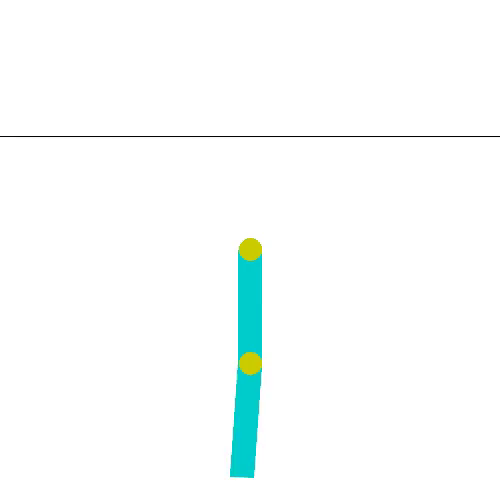

In [31]:
gym_simulation("Acrobot-v1")

### Advantage Computation

As we briefly touched upon in the policy gradients notebook, in RL the _advantage_ is a measure that
represents how much better a specific action is compared to the average action in a given state.
Repeating the formula above:

$
A_t(s_t, a_t) = G_t - V(s_t) = Q(s_t, a_t) - V(s_t) \approx [R_{t} + \gamma V_{t+1}] - V_t
$


In [3]:
def advantages_and_returns(gamma, rewards, dones, values, next_value):
    running_return = next_value
    returns = torch.zeros_like(rewards).to(DEVICE)
    for t in reversed(range(len(rewards))):
        mask = 1.0 - dones[t]
        running_return = rewards[t] + gamma * running_return * mask
        returns[t] = running_return
    advantages = returns - values
    return advantages, returns

### A2C Neural Networks

The actor learns a probability distribution over the possible actions, while the critic learns the
value for the state configuration.


In [ ]:
class ActorNetworkA2C(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits


class CriticNetworkA2C(nn.Module):
    def __init__(self, state_size, hidden_size=128):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

### A2C Agent


In [ ]:
class AgentA2C:
    def __init__(
        self,
        state_size,
        action_size,
        gamma=0.99,
        vloss_coeff=0.5,
        ent_coeff=0.01,
        learn_every=1000,
        lr=1e-3,
    ):
        self.gamma = gamma
        self.vloss_coeff = vloss_coeff
        self.ent_coeff = ent_coeff
        self.learn_every = learn_every

        self.actor = ActorNetworkA2C(state_size, action_size).to(DEVICE)
        self.critic = CriticNetworkA2C(state_size).to(DEVICE)
        self.optimizer = optim.Adam(
            list(self.actor.parameters()) + list(self.critic.parameters()), lr=lr
        )
        self.experiences = []

    @torch.no_grad()
    def act(self, state, add_noise=False):
        state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        probs = self.get_action_probs(state)
        action = probs.sample()
        return action.item()

    def step(self, state, action, reward, next_state, done):
        self.experiences.append(Experience(state, action, reward, next_state, done))
        if len(self.experiences) >= self.learn_every:
            self.learn()
            self.experiences = []

    def get_action_probs(self, states):
        logits = self.actor(states)
        return torch.distributions.Categorical(logits=logits)

    def learn(self):
        states, actions, rewards, next_states, dones = ReplayBuffer.unpack(self.experiences)

        probs = self.get_action_probs(states)
        logprobs = probs.log_prob(actions.squeeze(-1))
        entropy = probs.entropy().mean()
        values = self.critic(states).squeeze(-1)

        with torch.no_grad():
            next_state = next_states[-1]
            next_value = self.critic(next_state.unsqueeze(0)).squeeze(0)
            advantages, returns = advantages_and_returns(
                self.gamma, rewards.squeeze(-1), dones.squeeze(-1), values.detach(), next_value
            )

        policy_loss = -(logprobs * advantages).mean()
        value_loss = F.mse_loss(values, returns)
        loss = policy_loss + self.vloss_coeff * value_loss - self.ent_coeff * entropy

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(
            list(self.actor.parameters()) + list(self.critic.parameters()), max_norm=0.5
        )
        self.optimizer.step()

Episode 50	Average Score: -493.32
Episode 100	Average Score: -468.03
Episode 150	Average Score: -427.85
Episode 200	Average Score: -369.77
Episode 250	Average Score: -302.66
Episode 300	Average Score: -239.59
Episode 350	Average Score: -186.84
Episode 400	Average Score: -168.04
Episode 450	Average Score: -152.54
Episode 455 solved environment!	Average Score: -149.71


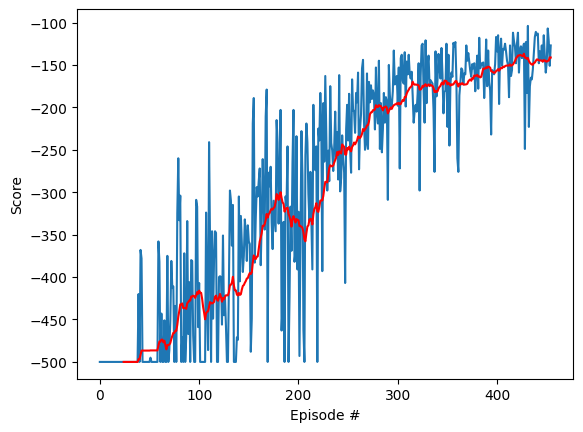

In [ ]:
with init_random(gym.make("Acrobot-v1")) as env:
    agent_a2c = AgentA2C(env.observation_space.shape[0], env.action_space.n)
    scores_a2c = train_actor_critic(env, agent_a2c, max_t=500, solved_score=-150)
plot_scores(scores_a2c)

MoviePy - Building file /tmp/rl-video.gif with imageio.


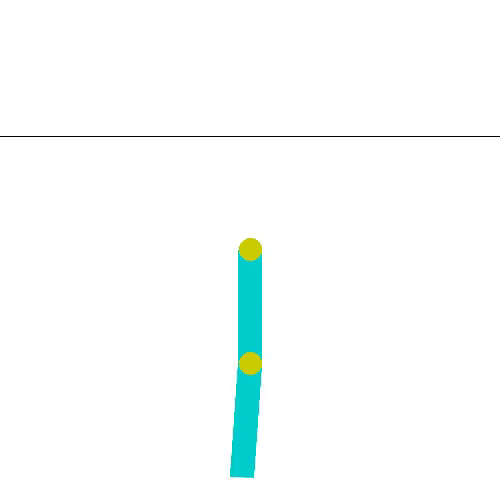

In [48]:
gym_simulation("Acrobot-v1", agent_a2c)

## Q-Learning Based Actor-Critic Algorithms

We are going to implement modern actor-critic algorithms such as DDPG, TD3, SAC. They are closely
related to Q-Learning, and in-between DQN and policy-gradient methods. All these algorithms are
analyzed in detail in [OpenAI SpinningUp](https://spinningup.openai.com/en/latest) and I strongly
recommend to read that amazing resource!

That is because these algorithms learn approximators for the optimal action-value function
$Q^*(s, a)$ and optimal (deterministic, excluding SAC) policy $a^*(s) = \argmax_{a} Q^*(s, a)$
exploting the fact that the action-value function is differentiable.

Finding the max of the action-value function would be an optimization problem in and of itself, but
instead we learn a deterministic policy $\mu(s)$ such that: $Q(s, \mu(s)) \approx \max_a Q^(s,a)$.
All of these algorithms are off-policy and use a replay buffer (like DQN).


### Environment

The `Pendulum-v1` environment is hard to learn from A2C. It is a continuous control problem that
needs very precise actions (networks and logprob computation need to be updated non-trivially);
rewards are very negative and smooth initially (the standard advantage computation might fall
short); exploration matters quite a bit. Q-Learning based algorithms work quite well instead.


In [2]:
# For convenience, harcoding actions' interval [-2.0, 2.0]
ACTION_SCALE = 2.0

Moviepy - Building video /tmp/rl-video-episode-0.mp4.
Moviepy - Writing video /tmp/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /tmp/rl-video-episode-0.mp4
MoviePy - Building file /tmp/rl-video.gif with imageio.


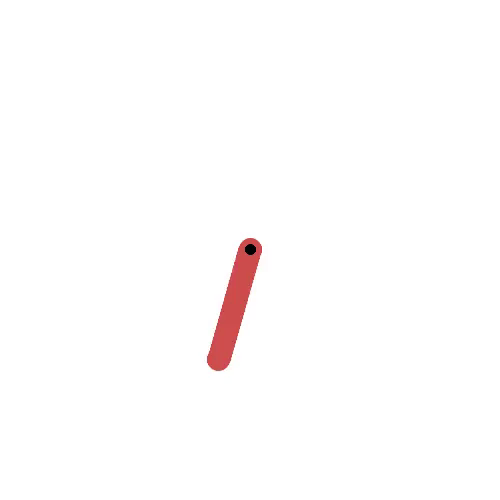

In [2]:
gym_simulation("Pendulum-v1")

### Neural Network Models

The action space is continuous, and the actor learns directly how to output the action. The critic
learns the Q function.


In [ ]:
class ActorNetworkQ(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=400, fc2_units=300):
        super(ActorNetworkQ, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x

In [ ]:
class CriticNetworkQ(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, fcs1_units=400, fc2_units=300):
        super(CriticNetworkQ, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

### DDPG

The _Deep Deterministic Policy Gradient_ algorithm can be thought the DQN algorithm for continuous
action spaces, and it uses the same techniques: replay-buffer + target-networks (for both actor and
critic).

We already leant how the _actor_ learns a deterministic policy $\mu(s)$ maximizing the critic value.
The _critic_ learns the action-value function $Q(s, a)$ minimizing a _mean-squared Bellman error_
(MSBE - the squared _advantage_ if you will) like DQN.

Because the policy is deterministic, the _exploration / exploitation_ tradeoff can be tuned adding
noise to the action. In the [original paper](https://proceedings.mlr.press/v32/silver14.pdf), the
authors recommended to use
[Ornstein-Uhlenbeck noise](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process), but it
turns out that a zero-mean Gaussian noise works just as well (hence, we'll use that here).


In [ ]:
class AgentDDPG:
    def __init__(
        self,
        state_size,
        action_size,
        start_mem_size=128,
        gamma=0.99,
        lr_actor=1e-4,
        lr_critic=1e-3,
        exploration_noise_scale=0.1,
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.start_mem_size = start_mem_size
        self.gamma = gamma
        self.exploration_noise_scale = exploration_noise_scale

        self.actor = ActorNetworkQ(state_size, action_size).to(DEVICE)
        self.actor_target = ActorNetworkQ(state_size, action_size).to(DEVICE)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_target.eval()
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)

        self.critic = CriticNetworkQ(state_size, action_size).to(DEVICE)
        self.critic_target = CriticNetworkQ(state_size, action_size).to(DEVICE)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_target.eval()
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)

        self.memory = ReplayBuffer()

    @torch.no_grad
    def act(self, state: np.array, add_noise=False):
        state = torch.from_numpy(state).float().to(DEVICE)
        action = self.actor(state).cpu().data.numpy()
        if add_noise:
            action += np.random.normal(size=self.action_size) * self.exploration_noise_scale
        return np.clip(action, -ACTION_SCALE, ACTION_SCALE)

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > self.start_mem_size:
            experiences = self.memory.sample()
            self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        with torch.no_grad():
            actions_next = self.actor_target(next_states)
            Q_targets_next = self.critic_target(next_states, actions_next)
            Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        Q_values = self.critic(states, actions)
        critic_loss = F.mse_loss(Q_values, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actions_pred = self.actor(states)
        actor_loss = -self.critic(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        soft_update_model_params(self.critic, self.critic_target)
        soft_update_model_params(self.actor, self.actor_target)

Episode 50	Average Score: -1298.19
Episode 100	Average Score: -1141.01
Episode 150	Average Score: -837.587
Episode 200	Average Score: -570.97
Episode 250	Average Score: -394.13
Episode 269 solved environment!	Average Score: -368.20


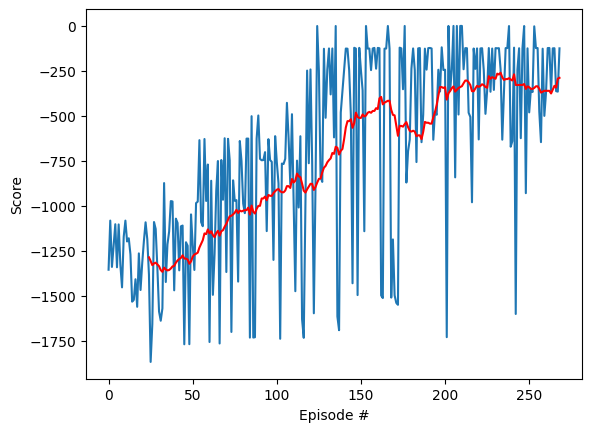

In [ ]:
with init_random(gym.make("Pendulum-v1")) as env:
    agent_ddpg = AgentDDPG(env.observation_space.shape[0], env.action_space.shape[0])
    scores_ddpg = train_actor_critic(env, agent_ddpg)
plot_scores(scores_ddpg)

MoviePy - Building file /tmp/rl-video.gif with imageio.


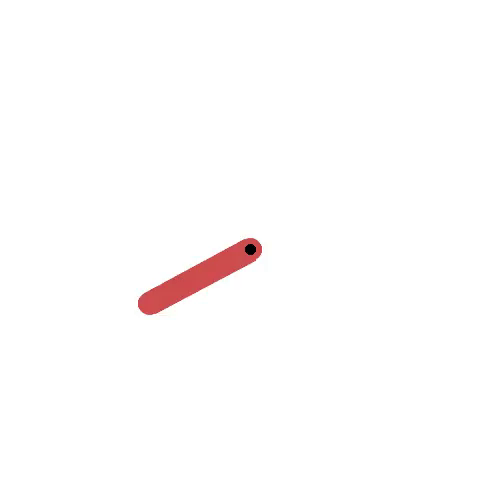

In [8]:
gym_simulation("Pendulum-v1", agent_ddpg)

### TD3

The _Twin Delayed DDPG_ (TD3) algorithm expands on DDPG with a couple of additional tricks:

- It learns _two_ Q functions, and uses the smaller Q value to for the target. That is to address
  overestimation of Q values in DDPG. The "_twin_" part of the name comes from this.
- Updates the policy (and target) networks less frequently than the Q function (hence, "_delayed_")
  and that is to keep the target and learning more stable.
- Finally, it adds noise to the target action to "smooth out" the action value and make it harder
  for the policy to exploit errors in the Q function.


In [ ]:
class AgentTD3:
    def __init__(
        self,
        state_size,
        action_size,
        start_mem_size=128,
        gamma=0.99,
        lr_actor=1e-4,
        lr_critic=1e-3,
        exploration_noise_scale=0.1,
        policy_noise=0.2,
        noise_clamp=0.5,
        policy_freq=2,
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.start_mem_size = start_mem_size
        self.gamma = gamma
        self.exploration_noise_scale = exploration_noise_scale
        self.policy_noise = policy_noise
        self.noise_clamp = noise_clamp
        self.policy_freq = policy_freq
        self.t_step = 0

        self.actor = ActorNetworkQ(state_size, action_size).to(DEVICE)
        self.actor_target = ActorNetworkQ(state_size, action_size).to(DEVICE)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_target.eval()
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)

        self.twin_critic_1 = CriticNetworkQ(state_size, action_size).to(DEVICE)
        self.twin_critic_target_1 = CriticNetworkQ(state_size, action_size).to(DEVICE)
        self.twin_critic_target_1.load_state_dict(self.twin_critic_1.state_dict())
        self.twin_critic_target_1.eval()
        self.twin_critic_2 = CriticNetworkQ(state_size, action_size).to(DEVICE)
        self.twin_critic_target_2 = CriticNetworkQ(state_size, action_size).to(DEVICE)
        self.twin_critic_target_2.load_state_dict(self.twin_critic_2.state_dict())
        self.twin_critic_target_2.eval()
        self.critic_optimizer = optim.Adam(
            list(self.twin_critic_1.parameters()) + list(self.twin_critic_2.parameters()),
            lr=lr_critic,
        )

        self.memory = ReplayBuffer()

    @torch.no_grad
    def act(self, state, add_noise=False):
        state = torch.from_numpy(state).float().to(DEVICE)
        action = self.actor(state).cpu().data.numpy()
        if add_noise:
            action += np.random.normal(size=self.action_size) * self.exploration_noise_scale
        return np.clip(action, -ACTION_SCALE, ACTION_SCALE)

    def step(self, state, action, reward, next_state, done):
        self.t_step += 1
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > self.start_mem_size:
            experiences = self.memory.sample()
            self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        with torch.no_grad():
            actions_next = self.actor_target(next_states)

            noise = torch.randn_like(actions_next, device=DEVICE) * self.policy_noise
            noise = noise.clamp(-self.noise_clamp, self.noise_clamp) * ACTION_SCALE
            actions_next += noise
            actions_next = actions_next.clamp(-ACTION_SCALE, ACTION_SCALE)

            Q_targets_next_1 = self.twin_critic_target_1(next_states, actions_next)
            Q_targets_next_2 = self.twin_critic_target_2(next_states, actions_next)
            Q_targets_next = torch.min(Q_targets_next_1, Q_targets_next_2)
            Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        Q_values_1 = self.twin_critic_1(states, actions)
        Q_values_2 = self.twin_critic_2(states, actions)
        critic_loss = F.mse_loss(Q_values_1, Q_targets) + F.mse_loss(Q_values_2, Q_targets)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        if self.t_step % self.policy_freq == 0:
            actions_pred = self.actor(states)
            Q_values = self.twin_critic_1(states, actions_pred)
            actor_loss = -Q_values.mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            soft_update_model_params(self.actor, self.actor_target)
            soft_update_model_params(self.twin_critic_1, self.twin_critic_target_1)
            soft_update_model_params(self.twin_critic_2, self.twin_critic_target_2)

Episode 50	Average Score: -1382.12
Episode 100	Average Score: -1328.69
Episode 150	Average Score: -1195.29
Episode 200	Average Score: -989.371
Episode 250	Average Score: -731.75
Episode 300	Average Score: -560.11
Episode 350	Average Score: -509.58
Episode 400	Average Score: -484.28
Episode 450	Average Score: -398.47
Episode 476 solved environment!	Average Score: -365.79


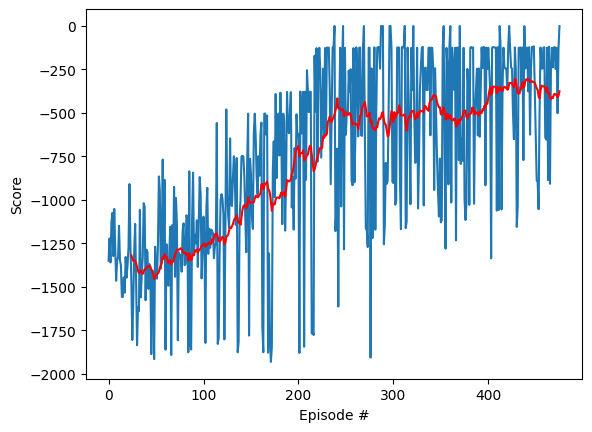

In [ ]:
with init_random(gym.make("Pendulum-v1")) as env:
    agent_td3 = AgentTD3(env.observation_space.shape[0], env.action_space.shape[0])
    scores_td3 = train_actor_critic(env, agent_td3)
plot_scores(scores_td3)

Moviepy - Building video /tmp/rl-video-episode-0.mp4.
Moviepy - Writing video /tmp/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /tmp/rl-video-episode-0.mp4
MoviePy - Building file /tmp/rl-video.gif with imageio.


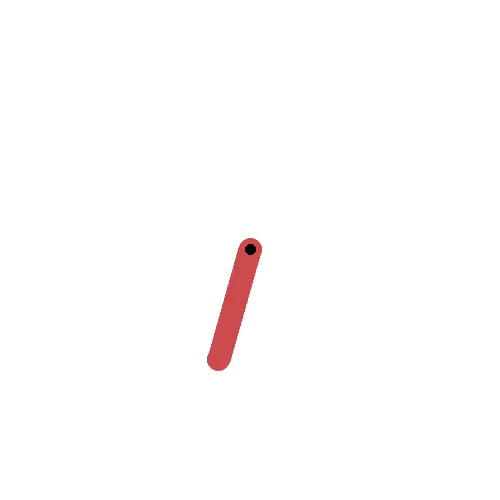

In [12]:
gym_simulation("Pendulum-v1", agent_td3)

### SAC (Optional)

The _Soft Actor Critic_ (SAC) algorithm is an off-policy algorithm similar to DDPG and TD3, that
learns a stochastic policy instead. It adopts many of the techniques used in TD3, but it stems from
the _Maximum Entropy Formulation_ of reinforcement learning.

For an in-depth understanding of both max-ent and SAC, I suggest watching
[Lecture 1](https://www.youtube.com/watch?v=2GwBez0D20A&list=PLwRJQ4m4UJjNymuBM9RdmB3Z9N5-0IlY0&index=2)
of Peter Abbeel Deep RL course, and reading the OpenAI SpinningUp SAC summary.

In short and as a highlight, in this formulation of RL the optimization objective is to maximize the
expected return plus the _entropy_ of the policy $H[ \pi (a | s_t)]$, term that intuitively balance
exploration and exploitation:

$$
\max_{\pi} \mathbb{E}\Bigl[ \sum_{t=0}^{T} r_t + \beta H[ \pi (a | s_t)] \Bigr]
$$

The _entropy_ in fact "measures" how uncertain is a policy (i.e., a deterministic policy has a very
low entropy, while a random one has high entropy).

While the _critic_ network learns the action-value as usual, the _actor_ network learns the mean and
standard deviation of a Gaussian representing the stochastic policy, using `tanh` to "squash" the
values in an acceptable range, and having the `logstd` depending on the network parameters as well.


In [ ]:
class ActorNetworkSAC(nn.Module):
    def __init__(self, state_size, action_size, action_scale=ACTION_SCALE, action_bias=0.0):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, action_size)
        self.fc_logstd = nn.Linear(256, action_size)
        self.action_scale = action_scale
        self.action_bias = action_bias

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        return mean, self.adjust_log_std(log_std)

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        # Reparameterization trick: this allows gradients to flow through sampling (SAC learns a
        # distribution and we need to learn mean / std). If we just do .sample() from a Normal
        # distribution, we cannot backpropagate through randomness. Basically, sampling becomes:
        #  action = (mean + std * ϵ) where ϵ ~ N(0, 1)
        # So now action is a determinstic function of parameters (mean, std) plus fixed noise, so
        # gradients can flow properly.
        sample = normal.rsample()
        output = torch.tanh(sample)
        action = output * self.action_scale + self.action_bias
        # Because we do tanh squashing and then action scaling above, the logprob computation needs
        # to take that into account as variable change. Consider random variable A ~ P(A), and we
        # transform it in U = tanh(A). Now the probability density of U say Q(U) can be written as:
        # Q(U) = P(A) * dA/dU. Now dU/dA is (1 - tanh(A)^2). Then dA/dU = 1 / (1 - U^2). Hence:
        # Q(U) = P(A) / (1 - U^2) that in log space becomes a subtraction.
        log_prob = normal.log_prob(sample)
        log_prob -= torch.log(self.action_scale * (1 - output.pow(2)) + 1e-6)
        log_prob = log_prob.sum(-1, keepdim=True)
        return action, log_prob

    def adjust_log_std(self, log_std):
        log_std_min, log_std_max = (-5, 2)  # From SpinUp / Denis Yarats
        return log_std_min + 0.5 * (log_std_max - log_std_min) * (log_std + 1)

In [ ]:
class AgentSAC:
    def __init__(
        self,
        state_size,
        action_size,
        start_mem_size=128,
        gamma=0.99,
        lr_actor=1e-4,
        lr_critic=1e-3,
        policy_freq=2,
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.start_mem_size = start_mem_size
        self.gamma = gamma
        self.policy_freq = policy_freq
        self.t_step = 0

        self.actor = ActorNetworkSAC(state_size, action_size).to(DEVICE)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)

        self.twin_critic_1 = CriticNetworkQ(state_size, action_size).to(DEVICE)
        self.twin_critic_target_1 = CriticNetworkQ(state_size, action_size).to(DEVICE)
        self.twin_critic_target_1.load_state_dict(self.twin_critic_1.state_dict())
        self.twin_critic_target_1.eval()
        self.twin_critic_target_1.load_state_dict(self.twin_critic_1.state_dict())

        self.twin_critic_2 = CriticNetworkQ(state_size, action_size).to(DEVICE)
        self.twin_critic_target_2 = CriticNetworkQ(state_size, action_size).to(DEVICE)
        self.twin_critic_target_2.load_state_dict(self.twin_critic_2.state_dict())
        self.twin_critic_target_2.eval()
        self.twin_critic_target_2.load_state_dict(self.twin_critic_2.state_dict())

        self.critic_optimizer = optim.Adam(
            list(self.twin_critic_1.parameters()) + list(self.twin_critic_2.parameters()),
            lr=lr_critic,
        )

        self.memory = ReplayBuffer()

    @torch.no_grad
    def act(self, state, add_noise=False):  # SAC doesn't really have noise, but for consistency...
        state = torch.from_numpy(state).float().to(DEVICE)
        action, _ = self.actor.get_action(state)
        return action.numpy()

    def step(self, state, action, reward, next_state, done):
        self.t_step += 1
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > self.start_mem_size:
            experiences = self.memory.sample()
            self.learn(experiences)

    def learn(self, experiences, alpha=0.2):
        states, actions, rewards, next_states, dones = experiences

        with torch.no_grad():
            actions_next, log_pi_next_st = self.actor.get_action(states)
            entropy_term = alpha * log_pi_next_st

            Q_targets_next_1 = self.twin_critic_target_1(next_states, actions_next)
            Q_targets_next_2 = self.twin_critic_target_2(next_states, actions_next)
            Q_targets_next = torch.min(Q_targets_next_1, Q_targets_next_2) - entropy_term
            Q_values = rewards + (self.gamma * Q_targets_next * (1 - dones))

        Q_expected_1 = self.twin_critic_1(states, actions)
        Q_expected_2 = self.twin_critic_2(states, actions)
        critic_loss = F.mse_loss(Q_expected_1, Q_values) + F.mse_loss(Q_expected_2, Q_values)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        if self.t_step % self.policy_freq == 0:
            action, log_pi = self.actor.get_action(states)
            entropy_term = alpha * log_pi

            Q_values_1 = self.twin_critic_1(states, action)
            Q_values_2 = self.twin_critic_2(states, action)
            Q_values = torch.min(Q_values_1, Q_values_2)
            actor_loss = (entropy_term - Q_values).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            soft_update_model_params(self.twin_critic_1, self.twin_critic_target_1)
            soft_update_model_params(self.twin_critic_2, self.twin_critic_target_2)

Episode 50	Average Score: -1495.55
Episode 100	Average Score: -1280.53
Episode 150	Average Score: -737.077
Episode 191 solved environment!	Average Score: -363.23


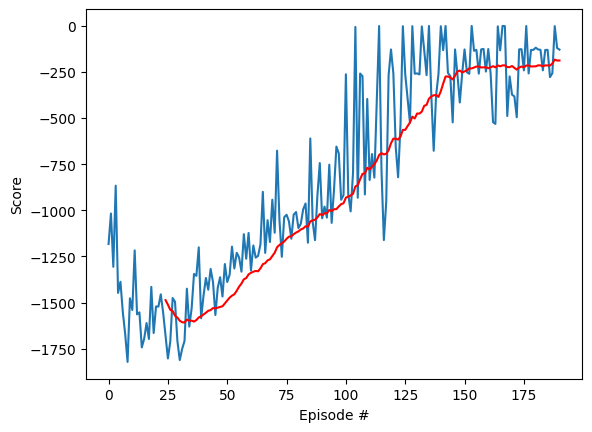

In [ ]:
with init_random(gym.make("Pendulum-v1")) as env:
    agent_sac = AgentSAC(env.observation_space.shape[0], env.action_space.shape[0])
    scores_sac = train_actor_critic(env, agent_sac)
plot_scores(scores_sac)

MoviePy - Building file /tmp/rl-video.gif with imageio.


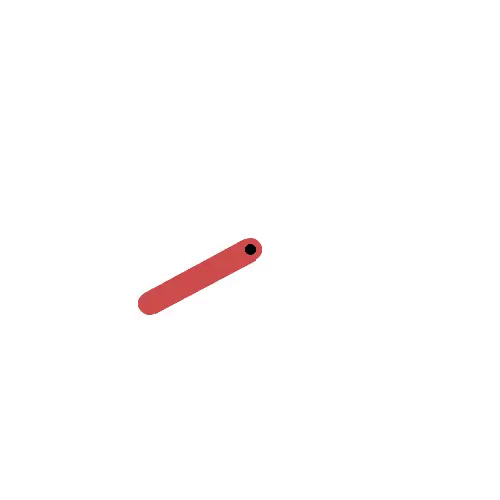

In [12]:
gym_simulation("Pendulum-v1", agent_sac)